## Modeling Panel Data with a Single LSTM Unit RNN

Author: Greg Strabel

The purpose of this notebook is to demonstrate the use of a Recurrent Neural Network, in this case a single LSTM unit, for modeling panel data. I generate data from a count process with a latent mean constructed from a set of unobserved autoregressive processes - one AR process for each level of two observed categorical variables.

In [2]:
# Import the Python modules used in the program below
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
%matplotlib inline

Using TensorFlow backend.


In [3]:
## Generate data
N = 200 # time dimension
np.random.seed(12345)
dates = pd.date_range('20000101', periods = N, freq='M')

cat_var_levels = [25,25] # 2 categorical variables with respective number of levels

cat_vars = [[str(i) for i in range(j)] for j in cat_var_levels]

# Construct shell of DataFrame with latent means
import itertools
colnames = ['Cat Var '+str(i) for i in range(len(cat_vars))]
df = pd.DataFrame(list(itertools.product(*cat_vars)), columns = colnames)
poisson_components = [np.random.poisson(10,size = i) for i in cat_var_levels]
df.loc[:,'Poisson Mean'] = np.array(
    [np.array([poisson_components[0][int(i)] for i in df.loc[:,j]])
     for j in df.columns.tolist()]).T.sum(axis=1)

# Construct AR(1) models
eps = [np.random.normal(scale=0.1,size=(i,N)) for i in cat_var_levels]
arma = [np.zeros_like(i) for i in eps]
for i in range(len(arma)):
    for j in np.arange(1,arma[i].shape[1]):
        arma[i][:,j] = 0.9*arma[i][:,j-1] + eps[i][:,j]

# Create specific month effects to imitate those found in insurance data
df_g = np.ones(shape=(df.shape[0],N))
# Add January effect:
df_g = df_g + np.broadcast_to((dates.month == 1).reshape(1,-1),df_g.shape)*0.1
# Add July effect:
df_g = df_g + np.broadcast_to((dates.month == 1).reshape(1,-1),df_g.shape)*0.05

# apply the modified AR processes to the Poisson means
for j in range(len(cat_var_levels)):
    df_g = df_g * np.maximum(1+np.array([arma[j][int(i),:] for i in df[colnames[j]].values]),0)

df = pd.concat([df,pd.DataFrame(df.loc[:,'Poisson Mean'].values.reshape(-1,1) * df_g, columns=dates)],axis=1)
df = df[colnames+dates.tolist()].\
    melt(id_vars = colnames, var_name = 'Date').\
    rename(columns = {'value':'Poisson Mean'}).\
    sort_values(colnames+['Date']).\
    reset_index(drop = True)
    
# Generate the actual response variable:
df.loc[:,'value'] = np.random.poisson(df.loc[:,'Poisson Mean'].values)

In [4]:
## Take a look at data
df.head()

,Cat Var 0,Cat Var 1,Date,Poisson Mean,value
0,0,0,2000-01-31,36.800000,36
1,0,0,2000-02-29,37.718286,29
2,0,0,2000-03-31,34.819431,36
3,0,0,2000-04-30,26.480502,22
4,0,0,2000-05-31,31.860761,40


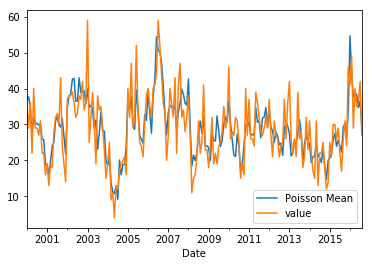

In [9]:
# Plot the time series for a specifc set of variable levels:
df.loc[((df['Cat Var 0']=='0') & (df['Cat Var 1']=='0')).values,['Date','Poisson Mean','value']].plot(x='Date')

In [10]:
## Construct lags
df2 = df.copy()
##
time_steps = 6 ## number of time steps in RNN
n_lags = 3 ## number of lagged observations

## Create lagged values:
for i in range(n_lags):
    df2['Lag ' + str(i+1)] = df2.groupby(colnames).value.shift(i+1).values
df2 = df2.dropna().reset_index(drop=True) # get rid of observations with less than a full set of lagged values

## Add month variable
df2.loc[:,'Month'] = df2.Date.map(lambda x: str(x.month)).astype('category')


## First Step is NA if there are not a full time_steps prior observations in the group
df2['First Step'] = df2.groupby(colnames).value.shift(time_steps).values
df2_noNA = df2.dropna() # drop observations that do not have a full time_steps prior observations in the group

In [11]:
## Take a look at the dataset with lags
## Records where First Step is NaN will be dropped for training
df2.head(10)

,Cat Var 0,Cat Var 1,Date,Poisson Mean,value,Lag 1,Lag 2,Lag 3,Month,First Step
0,0,0,2000-04-30,26.480502,22,36.0,29.0,36.0,4,NaN
1,0,0,2000-05-31,31.860761,40,22.0,36.0,29.0,5,NaN
2,0,0,2000-06-30,30.119925,29,40.0,22.0,36.0,6,NaN
3,0,0,2000-07-31,30.314476,29,29.0,40.0,22.0,7,NaN
4,0,0,2000-08-31,29.812291,27,29.0,29.0,40.0,8,NaN
5,0,0,2000-09-30,30.034769,31,27.0,29.0,29.0,9,NaN
6,0,0,2000-10-31,26.062964,22,31.0,27.0,29.0,10,22.0
7,0,0,2000-11-30,25.785346,22,22.0,31.0,27.0,11,40.0
8,0,0,2000-12-31,18.691263,16,22.0,22.0,31.0,12,29.0
9,0,0,2001-01-31,18.985680,19,16.0,22.0,22.0,1,29.0


In [12]:
## Construct the set of indices to use from df2 for each index in df2_noNA
exp_index = np.concatenate([np.arange(i-time_steps,i) for i in df2_noNA.index.tolist()])
## Construct the expanded DataFrame
exp_df = df2.iloc[exp_index,:]

## Construct the design matrix
dmat = np.concatenate([pd.get_dummies(exp_df[colnames+['Month']]).values,
                       exp_df[['Lag ' + str(i+1) for i in range(n_lags)]]], axis=1)
dmat = dmat.reshape(-1,time_steps,dmat.shape[1])

In [13]:
## Build train and test design matrices and targets

cutoff_date = dates[int(len(dates)*2/3)] # date to split train and test
mask = np.broadcast_to((df2_noNA.Date<=cutoff_date).values.reshape(-1,1,1),dmat.shape)
dmat_train = dmat[mask].reshape(-1,time_steps,dmat.shape[2])
dmat_test = dmat[~mask].reshape(-1,time_steps,dmat.shape[2])
Y_train = df2_noNA.loc[df2_noNA.Date<=cutoff_date,'value'].values
Y_test = df2_noNA.loc[df2_noNA.Date>cutoff_date,'value'].values

In [14]:
## Build and train single LSTM unit Neural Network
model = Sequential()
model.add(LSTM(1, input_shape=dmat_train.shape[1:], return_sequences=False, activation = 'relu'))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(dmat_train, Y_train, epochs=20, verbose = 2)

Epoch 1/20
12s - loss: 81.5437
Epoch 2/20
11s - loss: 54.2422
Epoch 3/20
11s - loss: 51.3142
Epoch 4/20
12s - loss: 50.4483
Epoch 5/20
12s - loss: 50.1052
Epoch 6/20
14s - loss: 49.8781
Epoch 7/20
13s - loss: 49.5994
Epoch 8/20
12s - loss: 49.5050
Epoch 9/20
12s - loss: 49.4343
Epoch 10/20
12s - loss: 49.3429
Epoch 11/20
11s - loss: 49.3119
Epoch 12/20
12s - loss: 49.2791
Epoch 13/20
11s - loss: 49.2137
Epoch 14/20
11s - loss: 49.1824
Epoch 15/20
11s - loss: 49.1126
Epoch 16/20
11s - loss: 49.1814
Epoch 17/20
11s - loss: 49.1237
Epoch 18/20
11s - loss: 49.1057
Epoch 19/20
11s - loss: 49.1245
Epoch 20/20
11s - loss: 49.0037


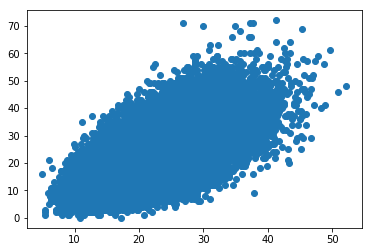

In [15]:
## Scatter plot model predictions vs actuals for test dataset
plt.scatter(model.predict(dmat_test),Y_test)

In [16]:
## Plot actuals vs predicteds vs latent mean for one specific combination of categorical variables
plot_mask = ((df2_noNA.Date>cutoff_date)&(df2_noNA['Cat Var 0']=='0')&(df2_noNA['Cat Var 1']=='0')).values
y_plot = df2_noNA[plot_mask].value.values
plot_dates = df2_noNA[plot_mask].Date
plot_latent_mean = df2_noNA[plot_mask]['Poisson Mean']
dmat_plot = dmat[np.broadcast_to(plot_mask.reshape(-1,1,1),dmat.shape)].reshape(-1,time_steps,dmat.shape[2])

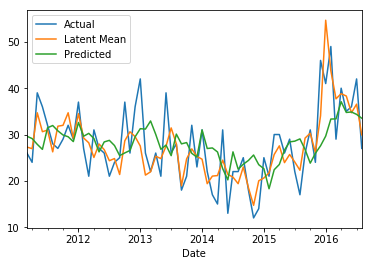

In [17]:
pd.DataFrame({'Actual' : y_plot, 'Predicted' : model.predict(dmat_plot).reshape(-1),
              'Latent Mean' : plot_latent_mean.values}, index = plot_dates).plot()

In [18]:
## Plot aggregated actuals vs predicteds vs latent mean
plot_mask = (df2_noNA.Date>cutoff_date).values
y_plot = df2_noNA[plot_mask].groupby('Date').sum().value.values.reshape(-1)
plot_dates = np.unique(df2_noNA[plot_mask].Date)
plot_latent_mean = df2_noNA[plot_mask].groupby('Date').sum()['Poisson Mean'].values.reshape(-1)
dmat_plot = dmat[np.broadcast_to(plot_mask.reshape(-1,1,1),dmat.shape)].reshape(-1,time_steps,dmat.shape[2])
preds = pd.DataFrame({'Predicted':model.predict(dmat_plot).reshape(-1),'Date':df2_noNA[plot_mask].Date}).\
    groupby('Date').sum().values.reshape(-1)

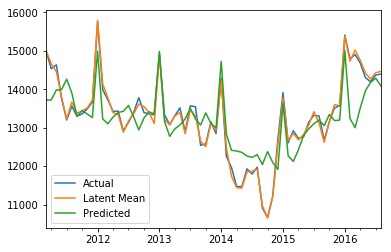

In [19]:
pd.DataFrame({'Actual' : y_plot, 'Predicted' : preds,
              'Latent Mean' : plot_latent_mean}, index = plot_dates).plot()

To gain better insight into the strength of this simple RNN relative to a more 'standard' model, I compare its performance to that of an equivalent AR(3) model

In [20]:
from sklearn import linear_model
reg = linear_model.LinearRegression(fit_intercept=False)
df_lin_mod = pd.concat([df2.loc[:,['Lag ' + str(i+1) for i in range(n_lags)] + ['value','Date']],
                       pd.get_dummies(df2[['Month']+colnames])], axis = 1)
reg.fit(df_lin_mod.loc[df_lin_mod.Date <= cutoff_date,
                       [c for c in df_lin_mod.columns.tolist() if c not in ['value','Date']]].values,
        df_lin_mod[df_lin_mod.Date <= cutoff_date].value.values)
#df2_test = df2.loc[df2.Date > cutoff_date].copy()
df_lin_mod['Linear Pred'] = reg.predict(df_lin_mod.loc[:,
                    [c for c in df_lin_mod.columns.tolist() if c not in ['value','Date']]].values)

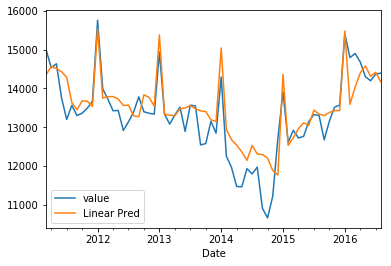

In [22]:
df_lin_mod.loc[df2.Date > cutoff_date].groupby('Date').sum().loc[:,['value','Linear Pred']].plot()

Just eyeballing the last two plots above suggests that the added complexity of an RNN did not provide any improvement over a far simpler AR(3) model. In this case Thoreau is probably right; 'Simplify, simplify.'

In [24]:
#pd.DataFrame({'Variable':[c for c in df_lin_mod.columns.tolist() if c not in ['value','Date','Linear Pred']],
#              'Coefficient':reg.coef_.reshape(-1)})